#   Airbnb in Seattle Analysis

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import seaborn as sns
import numpy as np
import os
%pylab inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
#lasso linear regression
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import sklearn

# 1. Data description

This project used the following dataset, which are available in  (**Datasource**: [Airbnb Seattle Data](https://www.kaggle.com/airbnb/seattle))   
And you can check the data from  [**Here**](https://github.com/juliaYi/Airbnb-Seattle-Data-Analysis/tree/master/dataset).

It has two tables. One is for hosting information. The other is for reviews. The hosting information table has <font color='red'>3818 rows</font> and each hosting has <font color='red'>92 attributes </font>. The review table has <font color='red'>84849 rows</font> and each review has <font color='red'>6 </font>attributes.

#### Rent information table has 5 groups of attributes:
##### 1)  host information: 
> host_id, host_is_superhost, host_response_time, host_response_rate, host_identity_verified,...
##### 2)  rent information: 
> price, name, description, neighborhood, smart_location, property_type, bedrooms, bathrooms,...
##### 3)  review information:
> first_review, last_review, review_scores_rating, number_of_reviews,...
##### 4)  policy information:
> requires_license, cancellation_policy,require_guest_profile_picture,...

#### Review information table has 6 attributes: 
>1) listing_id 
<br>2) id<br>3) date: review date.<br>4) reviewer_id<br>5) reviewer_name<br>6) comments

In [3]:
lst=pd.read_csv('listings.csv')

In [4]:
df = lst.drop(['listing_url', 'scrape_id', 'name', 'summary', 'space', 'description', 
               'experiences_offered', 'neighborhood_overview', 'notes', 'thumbnail_url', 'medium_url', 
               'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name',  
               'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'street',
               'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'calendar_updated',
               'calendar_last_scraped',  'license', 'jurisdiction_names',
               'weekly_price','monthly_price','transit','id'], axis= 1)

# 2. Data preparation

## 2.1 Delete symbols and convert to numeric type

In [7]:
df['host_response_rate'] = df['host_response_rate'].str.replace('%','')
df['host_acceptance_rate'] =df['host_acceptance_rate'].str.replace('%','')

In [8]:
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'])
df['host_acceptance_rate'] = pd.to_numeric(df['host_acceptance_rate'])

In [9]:
df['price'] =df['price'].str.replace('$','')
df['security_deposit'] =df['security_deposit'].str.replace('$','')
df['cleaning_fee'] =df['cleaning_fee'].str.replace('$','')
df['extra_people'] =df['extra_people'].str.replace('$','')

In [10]:
df['price'] =df['price'].str.replace(',','')
df['security_deposit'] =df['security_deposit'].str.replace(',','')
df['cleaning_fee'] =df['cleaning_fee'].str.replace(',','')
df['extra_people'] =df['extra_people'].str.replace(',','')

In [11]:
df['security_deposit'] = pd.to_numeric(df['security_deposit'])
df['cleaning_fee'] = pd.to_numeric(df['cleaning_fee'])
df['price'] = pd.to_numeric(df['price'])
df['extra_people'] = pd.to_numeric(df['extra_people'])

## 2.2 Check Outliers and Error

### 1) Outliers for Price

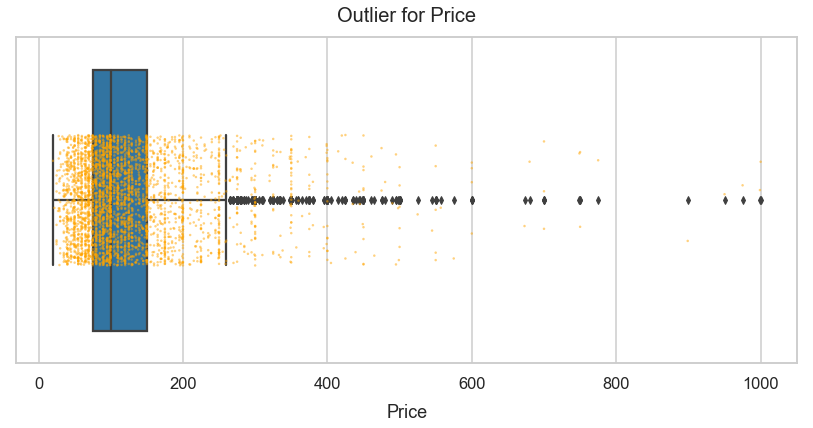

In [12]:
sns.set_context("talk")
sns.set_style("whitegrid")
plt.figure(figsize=(14,6))
sns.boxplot(x='price', data=df, orient='h')
sns.stripplot(x='price', data=df, color="orange", alpha=0.5, jitter=0.2, size=2.5)
plt.title("Outlier for Price", fontsize=20, y=1.03)
plt.xlabel("Price", fontsize=18, labelpad=12)
plt.savefig("image1.png");

In [13]:
df = df[df.price<800]

### 2) Outliers for bedrooms

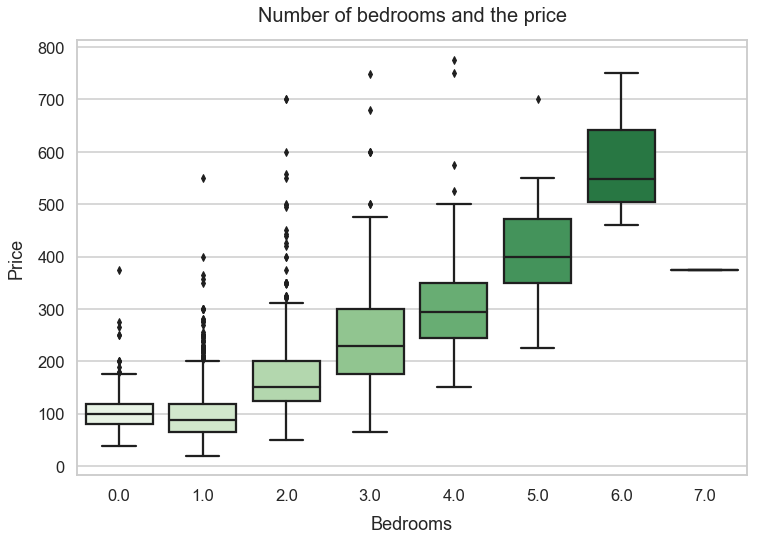

In [14]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bedrooms", y="price", palette="Greens", data=df)
plt.title("Number of bedrooms and the price", fontsize=20, y=1.03)
plt.xlabel("Bedrooms", fontsize=18, labelpad=12)
plt.ylabel("Price", fontsize=18, labelpad=12)
plt.savefig("image2.png");

 <font color='red'>The dataset only has one data point for seven bedrooms.</font>

In [15]:
df = df[df.bedrooms<7] # Delete one outlier.

### 3) Error for Zipcode

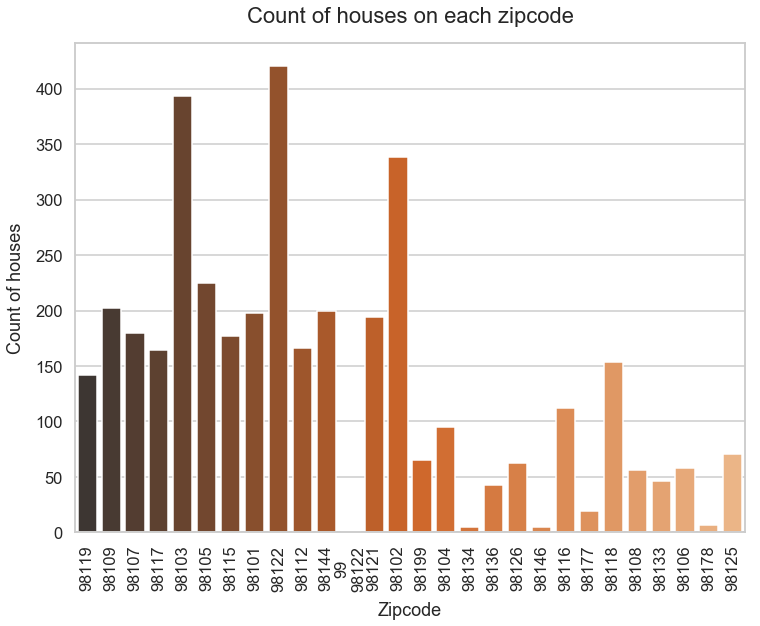

In [16]:
plt.figure(figsize=(12,9))
sns.countplot(x="zipcode", palette="Oranges_d", data=df)
plt.title("Count of houses on each zipcode", fontsize=22, y=1.03)
plt.xlabel("Zipcode", labelpad=10)
plt.ylabel("Count of houses", labelpad=10)
plt.xticks(rotation=90)
plt.savefig("image3.png");

<font color='red'>One zipcode seems like an error. </font>

In [17]:
df = df.drop(df[(df['zipcode']== '99\n98122')].index)

## 2.3 Create new variables: host_period, review_period

In [18]:
df['last_scraped'] = pd.to_datetime(df['last_scraped'])
df['host_since'] = pd.to_datetime(df['host_since'])

In [19]:
df['host_period'] = df['last_scraped']- df['host_since']
df['host_period'] = df['host_period'].dt.days

In [20]:
df['last_review'] = pd.to_datetime(df['last_review'])
df['first_review'] = pd.to_datetime(df['first_review'])

In [21]:
df['review_period'] = df['last_review']- df['first_review']
df['review_period'] = df['review_period'].dt.days

In [22]:
df = df.drop(['last_scraped','host_since','last_review','first_review'], axis = 1)

## 2.4 Plot data with cleaned data

### 1) Plot map with location and house price

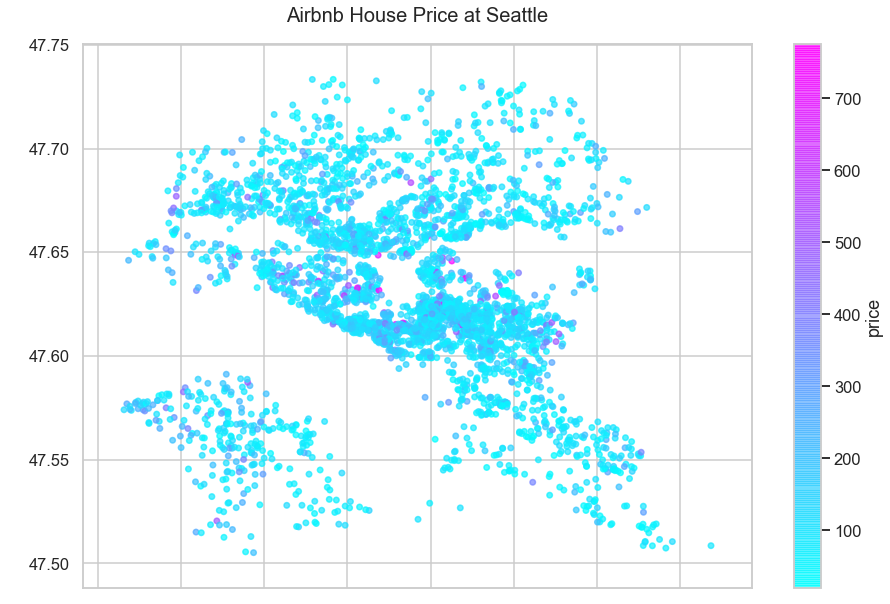

In [23]:
df.plot(kind="scatter", x="longitude", y="latitude",
    c="price", cmap="cool", s= 30,
    colorbar=True, alpha=0.7, figsize=(15,10),
)
plt.title('Airbnb House Price at Seattle', fontsize=20, y=1.03)
plt.ylabel(" ")
plt.savefig("image4.png");

### 2) Plot property type and price

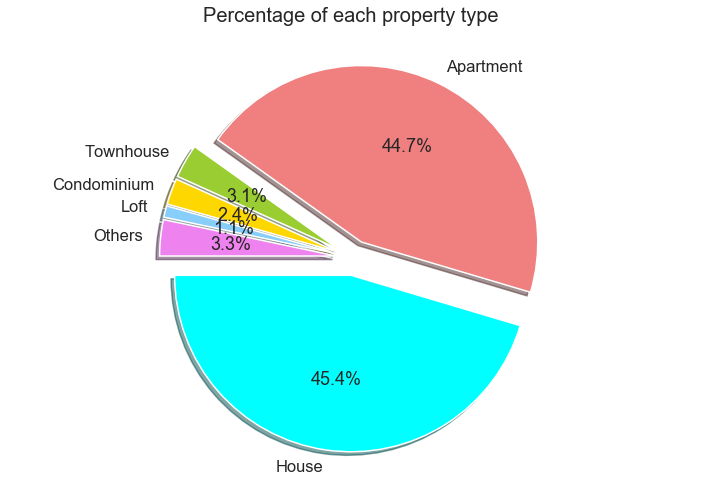

In [24]:
labels = 'House', 'Apartment', 'Townhouse', 'Condominium', "Loft", "Others"
sizes = [1727, 1702, 118, 91, 40, 126]
colors = ['cyan','lightcoral', 'yellowgreen', 'gold', 'lightskyblue', "violet"]
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # explode 1st slice
 
# Plot
plt.figure(figsize=(12,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.title("Percentage of each property type", fontsize=20, y=1.03)
plt.axis('equal')
plt.savefig("image5.png");

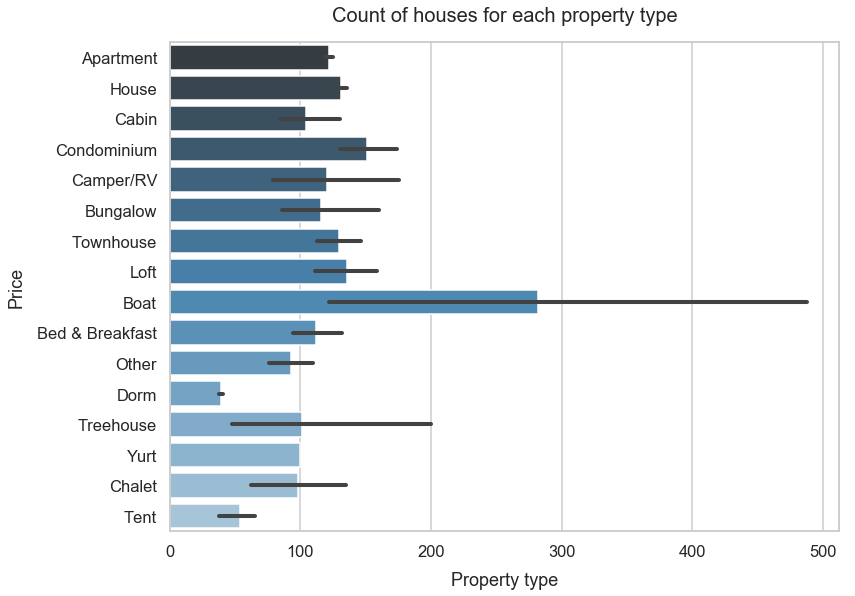

In [25]:
plt.figure(figsize=(12,9))
sns.barplot(x="price", y="property_type", palette="Blues_d", data=df)
plt.title("Count of houses for each property type", fontsize=20, y=1.03)
plt.xlabel("Property type", fontsize=18, labelpad=12)
plt.ylabel("Price", fontsize=18, labelpad=12)
plt.savefig("image6.png");

<font color='red'>Property type Boat owns the biggest price variance. The highest price is much higher than others</font>

### 3) Plot room type and price

In [26]:
roomtype_and_price = df.groupby("room_type").agg({"price": "mean"}).reset_index()

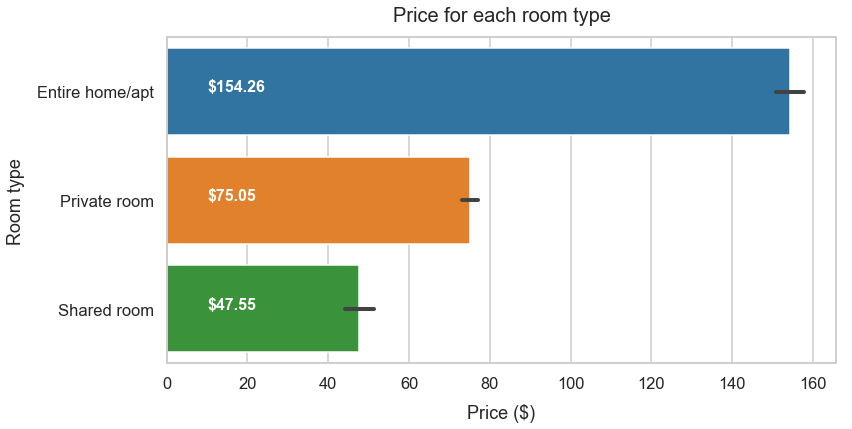

In [27]:
sns.set_context("talk")
plt.figure(figsize=(12,6))
ax= sns.barplot(x='price', y="room_type", data=df, orient='h')
plt.title("Price for each room type", fontsize=20, y=1.03)
plt.xlabel("Price ($)", fontsize=18, labelpad=12)
for index, row in roomtype_and_price.iterrows():
    ax.text(10, index, '$'+ str(round(row["price"],2)), color="white", weight="bold", fontsize=16)
plt.ylabel("Room type", fontsize=18, labelpad=12)
plt.savefig("image7.png");

### 5) Plot number_of_reviews and price

In [28]:
df['number_of_reviews_bins'] = pd.cut(df['number_of_reviews'], bins = [0,2,9,26,474])

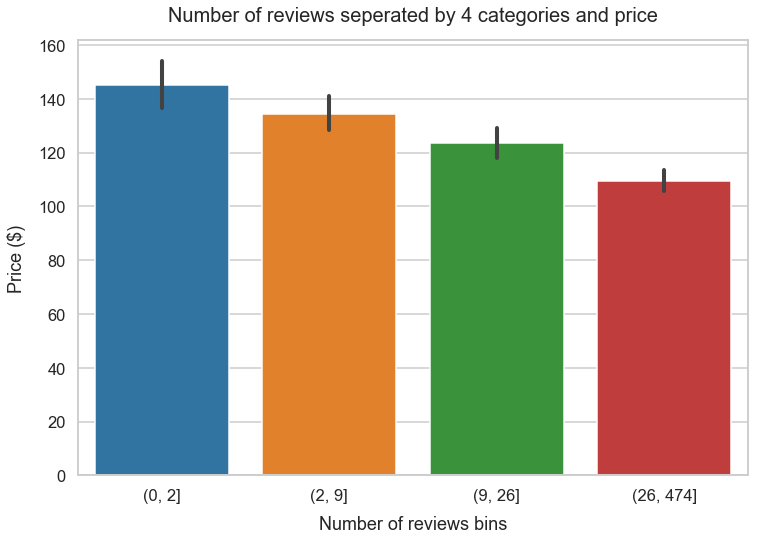

In [29]:
plt.figure(figsize=(12,8))
sns.barplot(x="number_of_reviews_bins", y="price", data=df)
plt.title("Number of reviews seperated by 4 categories and price", fontsize=20, y=1.03)
plt.xlabel("Number of reviews bins", fontsize=18, labelpad=12)
plt.ylabel("Price ($)", fontsize=18, labelpad=12)
plt.savefig("image8.png");

### 6) Plot cancellation policy and price

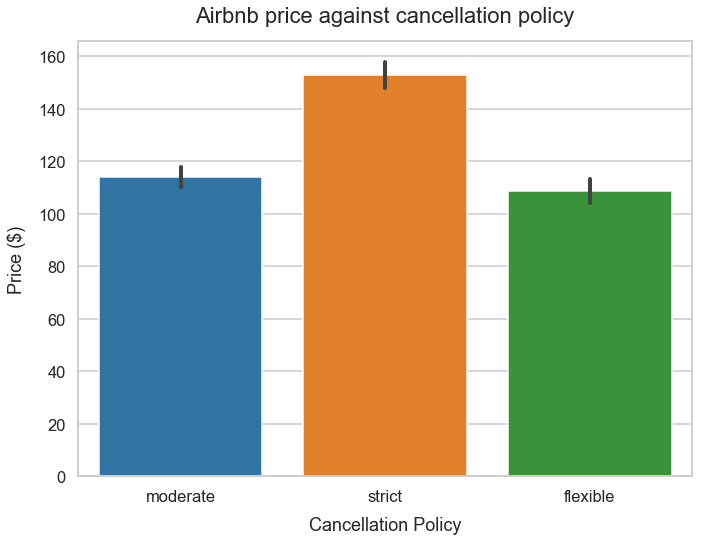

In [68]:
plt.figure(figsize=(11,8))
sns.barplot(x='cancellation_policy', y = 'price', data = df_ori)
plt.title("Airbnb price against cancellation policy", fontsize=22, y=1.03)
plt.ylabel("Price ($)", labelpad=12)
plt.xlabel("Cancellation Policy", labelpad=12)
plt.savefig("image12.png");

## 2.4 Deal with missing value and get dummy variables

In [30]:
cols= ['review_scores_rating','review_scores_accuracy',
               'review_scores_cleanliness','review_scores_checkin',
                'review_scores_communication','review_scores_location',
               'review_scores_value','reviews_per_month','review_period']
mask = df.number_of_reviews == 0
df.loc[mask,cols]=0

In [31]:
df = df.drop(['square_feet'], axis= 1)

In [32]:
df['superhost']=np.where(df['host_is_superhost']=='t',1,0)
df.drop('host_is_superhost',axis =1 , inplace = True)

In [33]:
df['instantbook']=np.where(df['instant_bookable']=='t',1,0)
df.drop('instant_bookable',axis =1 , inplace = True)

In [34]:
df_ori = df.copy()

In [35]:
df = pd.get_dummies(data = df, columns = ['host_neighbourhood','host_has_profile_pic',
                                          'host_identity_verified','neighbourhood',
                                          'neighbourhood_cleansed',
                                          'neighbourhood_group_cleansed', 'zipcode',
                                          'is_location_exact', 'property_type',
                                          'room_type', 'bed_type', 'cancellation_policy',
                                          'require_guest_profile_picture',
                                          'require_guest_phone_verification',
                                          'has_availability', 'requires_license',
                                          'host_response_time', 'number_of_reviews_bins'],dummy_na=True)

In [36]:
df = df.dropna()

In [37]:
len(df)

1369

## 2.5 Deal with host_verfications variable

In [38]:
df['email'] = df['host_verifications'].apply(lambda x: 1 if "email" in x else 0 )
df['phone'] = df['host_verifications'].apply(lambda x: 1 if "phone" in x else 0 )
df['facebook'] = df['host_verifications'].apply(lambda x: 1 if "facebook" in x else 0 )
df['google'] = df['host_verifications'].apply(lambda x: 1 if "google" in x else 0 )
df['linkedin'] = df['host_verifications'].apply(lambda x: 1 if "linkedin" in x else 0 )
df['reviews'] = df['host_verifications'].apply(lambda x: 1 if "reviews" in x else 0 )
df['jumio'] = df['host_verifications'].apply(lambda x: 1 if "jumio" in x else 0 )
df['kba'] = df['host_verifications'].apply(lambda x: 1 if "kba" in x else 0 )
df['manual_online'] = df['host_verifications'].apply(lambda x: 1 if "manual_online" in x else 0 )
df['manual_offline'] = df['host_verifications'].apply(lambda x: 1 if "manual_offline" in x else 0 )
df['sent_id'] = df['host_verifications'].apply(lambda x: 1 if "sent_id" in x else 0 )
df['amex'] = df['host_verifications'].apply(lambda x: 1 if "amex" in x else 0 )

In [39]:
df['TV'] = df['amenities'].apply(lambda x: 1 if ("TV"or"Cable TV") in x else 0 )
df['Internet'] = df['host_verifications'].apply(lambda x: 1 if "Internet" in x else 0 )
df['Air Conditioning'] = df['host_verifications'].apply(lambda x: 1 if "Air Conditioning" in x else 0 )
df['Kitchen'] = df['host_verifications'].apply(lambda x: 1 if "Kitchen" in x else 0 )
df['Heating'] = df['host_verifications'].apply(lambda x: 1 if "Heating" in x else 0 )
df['Family/Kid Friendly'] = df['host_verifications'].apply(lambda x: 1 if "Family/Kid Friendly" in x else 0 )
df['Washer'] = df['host_verifications'].apply(lambda x: 1 if "Washer" in x else 0 )
df['Dryer'] = df['host_verifications'].apply(lambda x: 1 if "Dryer" in x else 0 )
df['Free Parking on Premises'] = df['host_verifications'].apply(lambda x: 1 if "Free Parking on Premises" in x else 0 )
df['Smoke Detector'] = df['host_verifications'].apply(lambda x: 1 if "Smoke Detector" in x else 0 )
df['Carbon Monoxide Detector'] = df['host_verifications'].apply(lambda x: 1 if "Carbon Monoxide Detector" in x else 0 )
df['First Aid Kit'] = df['host_verifications'].apply(lambda x: 1 if "First Aid Kit" in x else 0 )
df['Safety Card'] = df['host_verifications'].apply(lambda x: 1 if "Safety Card" in x else 0 )
df['Fire Extinguisher'] = df['amenities'].apply(lambda x: 1 if "Fire Extinguisher" in x else 0 )
df['Essentials'] = df['host_verifications'].apply(lambda x: 1 if "Essentials" in x else 0 )
df['Shampoo'] = df['host_verifications'].apply(lambda x: 1 if "Shampoo" in x else 0 )
df['Breakfast'] = df['host_verifications'].apply(lambda x: 1 if "Breakfast" in x else 0 )
df['Pets live on this property'] = df['host_verifications'].apply(lambda x: 1 if "Pets live on this property" in x else 0 )
df['Hangers'] = df['host_verifications'].apply(lambda x: 1 if "Hangers" in x else 0 )
df['Hair Dryer'] = df['host_verifications'].apply(lambda x: 1 if "Hair Dryer" in x else 0 )
df['Laptop Friendly Workspace'] = df['host_verifications'].apply(lambda x: 1 if "Laptop Friendly Workspace" in x else 0 )
df['Elevator in Building'] = df['host_verifications'].apply(lambda x: 1 if "Elevator in Building" in x else 0 )
df['Hot Tub'] = df['host_verifications'].apply(lambda x: 1 if "Hot Tub" in x else 0 )
df['Indoor Fireplace'] = df['host_verifications'].apply(lambda x: 1 if "Indoor Fireplace" in x else 0 )
df['Buzzer/Wireless Intercom'] = df['host_verifications'].apply(lambda x: 1 if "Buzzer/Wireless Intercom" in x else 0 )
df['Iron'] = df['host_verifications'].apply(lambda x: 1 if "Iron" in x else 0 )

In [40]:
df = df.drop(['host_verifications','amenities'],axis=1)

## 2.6 Prepare for Machine learning

In [41]:
X = df.drop('price', axis =1)
Y = df.price

### <font color = 'red'> *First finding*</font>: Superhost charge more when there is more competition, and charge less when there is less competition

### <font color = 'blue'>Summary </font> : After running regression to predict airbnb rent price for host, I found that superhost in more competitive regions charge higer rent than superhost in less competitive regions

# 3. Use regression to suggest rent price for airbnb host 

## 3.1 Lasso Linear regressor

In [42]:
regLasso = linear_model.Lasso()
regLasso.fit(X,Y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [43]:
s = pd.Series({X.columns[i] : regLasso.coef_[i]
               for i in range(0,len(X.columns))} )
n = s[s != 0].sort_values(ascending = False)
n

bathrooms                                           28.714831
room_type_Entire home/apt                           23.430405
neighbourhood_group_cleansed_Downtown               22.463933
bedrooms                                            19.380924
zipcode_98109                                       15.951054
superhost                                            9.023784
accommodates                                         5.383960
neighbourhood_group_cleansed_Capitol Hill            4.882815
host_response_time_within a few hours                4.309032
guests_included                                      3.183389
zipcode_98101                                        3.043106
review_scores_location                               1.812789
linkedin                                             1.708265
host_listings_count                                  1.043521
review_scores_rating                                 0.762924
neighbourhood_group_cleansed_Queen Anne              0.621435
cleaning

In [44]:
temp_df = pd.DataFrame()
temp_df['feature']=n[n.values>5].index
temp_df['coefficient'] = n[n.values>5].values

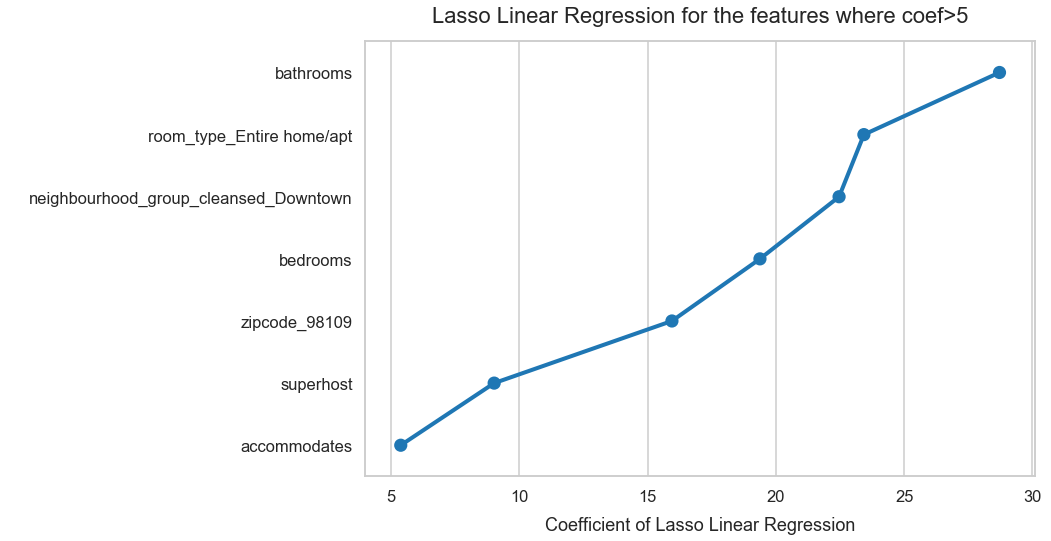

In [45]:
plt.figure(figsize=(12,8))
sns.pointplot(x='coefficient', y='feature', data=temp_df)
plt.title("Lasso Linear Regression for the features where coef>5", fontsize=22, y=1.03)
plt.xlabel("Coefficient of Lasso Linear Regression", labelpad=12)
plt.ylabel(" ")
plt.savefig("image9.png");

**<font color='blue'>Interesting question</font> :  The coefficient of <font color='red'>superhost</font>  is positive and relatively high. I am interested in <font color='red'>whether 'super host' has the same impact on price in neighbourhood group area list in the gragh as in other areas.</font> **

**Definition of 'Superhost': Superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests. Once a host reaches Superhost status, a badge will automatically appear on their listing and profile to help you identify them.**

**Airbnb says that "Superhosts earn 22% more than other hosts* and benefit from a variety of rewards." **

## 3.2 Gradient Boosting Regressor for Prediction

In [46]:
#gradient boosting
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4,random_state=0)

In [47]:
gb = GradientBoostingRegressor(random_state = 0)
gb.fit(X_train, Y_train)
Y_pred_gb = gb.predict(X_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

## 3.3 Metrics

Mean absolute error / Mean Absolute Deviation (MAD) :  <font color='red'>32.65$ prediction difference on price </font>

In [48]:
(Y_pred_gb - Y_test).abs().mean()

32.65394048039968

Average Percentage Error / APE: <font color='red'>24%</font>

In [49]:
((Y_test - Y_pred_gb)/(Y_test)).abs().mean()

0.24305511440816266

## 3.4 Find best regressor

In [50]:
regs = [linear_model.Lasso(), 
        ElasticNet(), 
        DecisionTreeRegressor(),
        GradientBoostingRegressor(), 
        MLPRegressor(),
        SVR(),
        RandomForestRegressor(),
        Ridge()]

In [51]:
minMAD = 10000000
for reg in regs:
    kf = KFold(random_state=0,shuffle=True)
    mad = sklearn.model_selection.cross_val_score(reg,X,Y,
             cv=kf,scoring='neg_mean_absolute_error').mean()
    # need the lowest scoring for mad
    print (str(reg)[:25] + ' with mad= ' + str(mad) )
    if mad < minMAD:
        minMAD = mad
        bestREG = reg
        
print('***********************************************')
print ('Best Regressor is... ' + str(bestREG)[:25] )
print('**********************')
print ('With MAD Score ' + str(minMAD))

Lasso(alpha=1.0, copy_X=T with mad= -34.91741618406055
ElasticNet(alpha=1.0, cop with mad= -36.54770636551738
DecisionTreeRegressor(cri with mad= -43.89524709841709
GradientBoostingRegressor with mad= -32.025109540137386
MLPRegressor(activation=' with mad= -41.5299358372481
SVR(C=1.0, cache_size=200 with mad= -58.39730651976726
RandomForestRegressor(boo with mad= -33.52424613228914
Ridge(alpha=1.0, copy_X=T with mad= -38.522752317291925
***********************************************
Best Regressor is... SVR(C=1.0, cache_size=200
**********************
With MAD Score -58.39730651976726


<font color='red'>The best regressor is SVR regressor. </font>

## 3.5 Deep analysis for super host

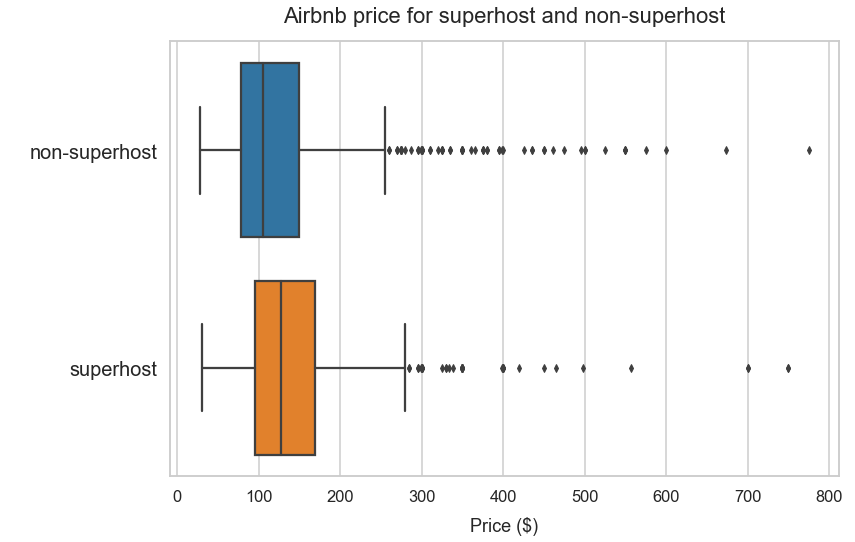

In [52]:
plt.figure(figsize=(12,8))
yticks=['non-superhost', 'superhost']
sns.boxplot(y="superhost", x="price", data=df, orient='horizontal');
plt.title("Airbnb price for superhost and non-superhost", fontsize=22, y=1.03)
plt.xlabel("Price ($)", labelpad=12)
plt.ylabel(" ")
plt.yticks(np.arange(0, 2, step=1), yticks, fontsize=20)
plt.savefig("image10.png");

**The average price and its variance with super host is higher than that with non super host. **

In [53]:
df.columns = [c.replace(' ', '_') for c in df.columns]

In [54]:
df['neighbourhood_group_cleansed_Queen_Anne']=pd.to_numeric(df['neighbourhood_group_cleansed_Queen_Anne'])

In [55]:
df['competition']= ((df.neighbourhood_group_cleansed_Downtown == 1)|(df.neighbourhood_group_cleansed_Capitol_Hill == 1)| (df.neighbourhood_group_cleansed_Queen_Anne == 1))*1.0

In [56]:
df['competition']= df['competition'].apply(lambda x: 'Yes' if x==1 else 'No')

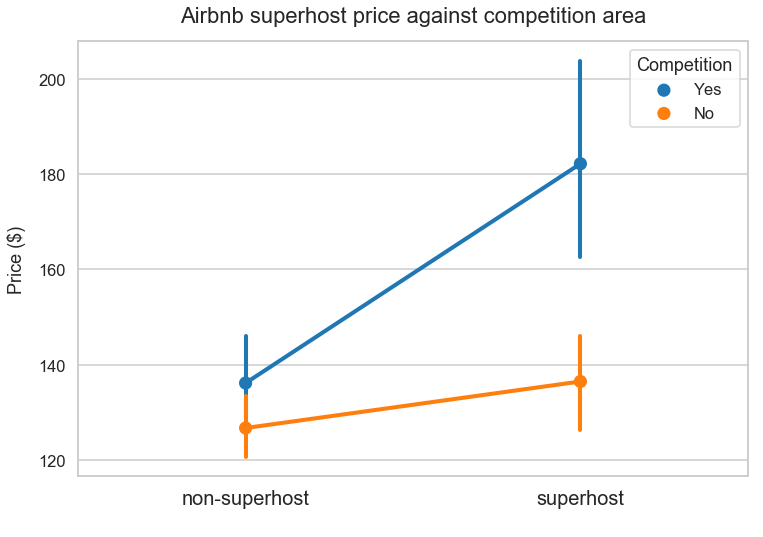

In [57]:
plt.figure(figsize=(12,8))
xticks=['non-superhost', 'superhost'] 
sns.pointplot(x = 'superhost', y = 'price', hue = 'competition', data = df)
plt.title("Airbnb superhost price against competition area", fontsize=22, y=1.03)
plt.ylabel("Price ($)", labelpad=12)
plt.xlabel(" ")
plt.xticks(np.arange(0, 2, step=1), xticks, fontsize=20)
plt.legend(title="Competition")
plt.savefig("image11.png");

**Conclusion : Hosts in competition area including Downtown, Capitol Hill, Queen Anne prefer to get more price benefit from their superhost badge. This might because there are more rent demands in competition area than others.**

** <font color='blue'> Manergial insight on Customer perspective </font>: for competition area, try not to choose superhost and for non-competition area, try superhost house rental.**

# <font color = 'red'> *Second finding*</font>: Airbnb price goes against  cancellation policy especially for entire house rentals!

### <font color='blue'>Summary </font> : After clustering, I found that entrie house host with strict cancellation policy holders tend to charge more. 

# 4. Use Clustering method for further analysis 

## 4.1 Use KMeans to find 3 clusters

In [58]:
df['competition']= ((df.neighbourhood_group_cleansed_Downtown == 1)|(df.neighbourhood_group_cleansed_Capitol_Hill == 1)| (df.neighbourhood_group_cleansed_Queen_Anne == 1))*1.0

In [59]:
from sklearn.cluster import KMeans

In [60]:
clu = KMeans(n_clusters=4, random_state=0)

In [61]:
clu

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [62]:
clu.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [63]:
clu.labels_

array([0, 0, 0, ..., 2, 0, 3], dtype=int32)

## 4.2 Getting summary information on the clusters' characteristics

In [64]:
d1 = df.copy()

In [65]:
d1['cluster']=clu.labels_

In [66]:
d_cluster = d1.groupby('cluster').mean()
d_cluster

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,Pets_live_on_this_property,Hangers,Hair_Dryer,Laptop_Friendly_Workspace,Elevator_in_Building,Hot_Tub,Indoor_Fireplace,Buzzer/Wireless_Intercom,Iron,competition
cluster,,,,,,,,,,,,,,,,,,,,,
0,96.272321,100.000000,3.776786,3.776786,47.624629,-122.333180,3.977679,1.343750,1.531250,2.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258929
1,95.777154,99.812734,7.234082,7.234082,47.624962,-122.332953,3.698502,1.260300,1.318352,1.859551,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436330
2,94.434641,100.000000,10.859477,10.859477,47.632826,-122.332839,3.964052,1.328431,1.493464,2.065359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.267974
3,96.967213,100.000000,2.268852,2.268852,47.631042,-122.334024,3.816393,1.326230,1.393443,1.950820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363934


In [97]:
df_cluster = d_cluster[['price','cancellation_policy_strict']].reset_index()

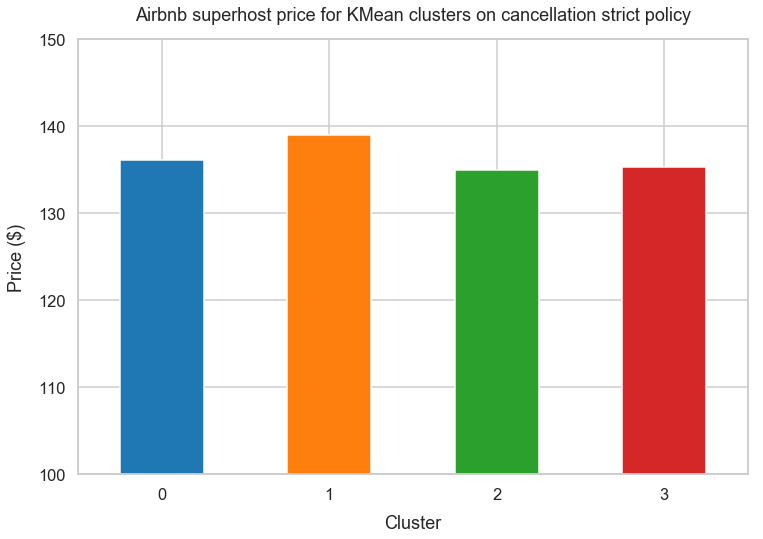

In [120]:
df_cluster.plot(kind='bar', x='cluster', y='price', figsize=(12,8), legend=False)
plt.title("Airbnb superhost price for KMean clusters on cancellation strict policy", y=1.03)
plt.ylabel("Price ($)", labelpad=12)
plt.xlabel("Cluster", labelpad=12)
plt.ylim(100,150)
plt.xticks(rotation=360)
plt.savefig("image12.png");

## 4.3 Finding the best clustering method

In [71]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering

In [72]:
bestSil = -1
for k in range(2,6):
    clus = [KMeans(n_clusters=k,n_jobs=-1), Birch(n_clusters=k), AgglomerativeClustering(n_clusters=k)]
    for cl in clus:
        res = cl.fit(df)
        sil = metrics.silhouette_score(df, res.labels_)
        print (str(cl)[:10] + ' with k=' +str(k) + ": " + str(round(sil,4)))
        if (sil > bestSil):
            bestSil = sil
            bestCl = cl
            bestK = k
print('***********************************************')
print ('Best algorithm is... ' + str(bestCl)[:8] + '     with k=' +str(bestK) )
print('**********************')
print ('With Silhouette Score ' + str(bestSil))

KMeans(alg with k=2: 0.3936
Birch(bran with k=2: 0.3916
Agglomerat with k=2: 0.3916
KMeans(alg with k=3: 0.392
Birch(bran with k=3: 0.3743
Agglomerat with k=3: 0.3743
KMeans(alg with k=4: 0.4021
Birch(bran with k=4: 0.3885
Agglomerat with k=4: 0.3885
KMeans(alg with k=5: 0.3796
Birch(bran with k=5: 0.3683
Agglomerat with k=5: 0.3683
***********************************************
Best algorithm is... KMeans(a     with k=4
**********************
With Silhouette Score 0.402128157913392


In [69]:
df_ori['cancellation_strict'] = df_ori['cancellation_policy'].apply(lambda x: 'Yes' if x=='strict' else 'No')

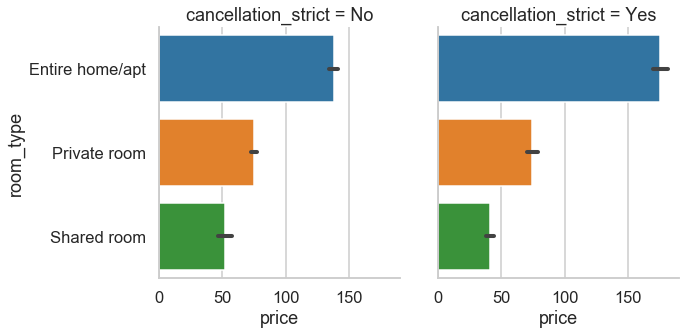

In [131]:
sns.catplot(y='room_type', x='price', col = 'cancellation_strict', kind='bar', data=df_ori)
plt.savefig("image13.png");

In [135]:
df_ori['room_type'].value_counts()/len(df_ori)*100

Entire home/apt    66.465177
Private room       30.459921
Shared room         3.074901
Name: room_type, dtype: float64

** <font color='blue'>Managerial insight </font> : Seeing the basic plots and clustering result, there seems to have assiociation with higher price and strict cancellation policy. ** 

** Considering there are dominant number of house listing for entire house room type and seeing the plot on room type and cancellation policy, it can be concluded that for hosts who want to rent entire house and have strict cancellation policy charge around 50 dollars more. As a result, it is recommendable for customers who want to rent entire house that they should avoid renting house from hosts who have strict cancellation policy.**

# <font color = 'red'>*Third finding*</font>:  Most People don’t satisfy with their booking because of communication related issues. 

### <font color = 'blue'>Summary</font>: After running regression and decision tree analysis, I found cummunication and cleaniness are important (communication is more important than cleaniness)

# 5. Use combination of regression and sentiment analysis to deeply dive into customers' needs.

In [89]:
from sklearn import linear_model
regLasso = linear_model.Lasso()

In [90]:
df['review_scores_rating'].mean() 

84.821767713659611

Review scores rating mean is pretty high 

## 5.1 Plot review_scores rating and location, communication

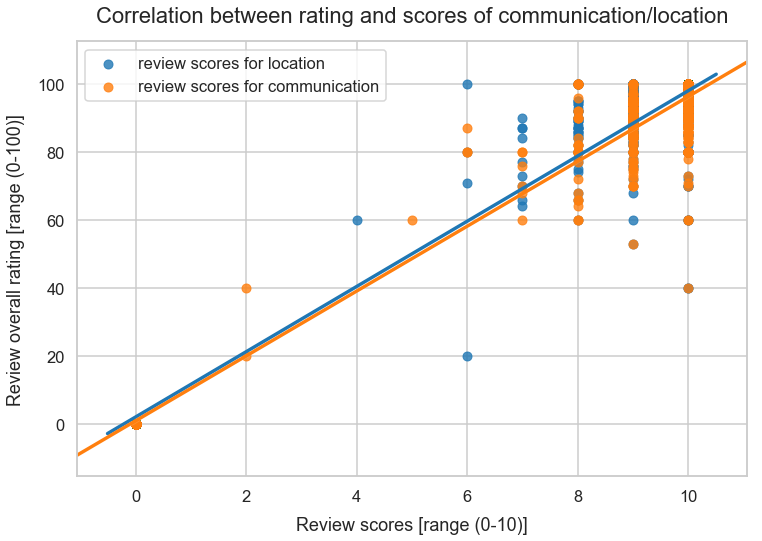

In [83]:
plt.figure(figsize=(12,8))
sns.regplot(x='review_scores_location', y='review_scores_rating', label='review scores for location', data=df)
sns.regplot(x='review_scores_communication', y='review_scores_rating', label='review scores for communication', data=df)
plt.legend()
plt.title("Correlation between rating and scores of communication/location", fontsize=22, y=1.03)
plt.ylabel("Review overall rating [range (0-100)]", labelpad=12)
plt.xlabel("Review scores [range (0-10)]", labelpad=12)
plt.savefig("image14.png");

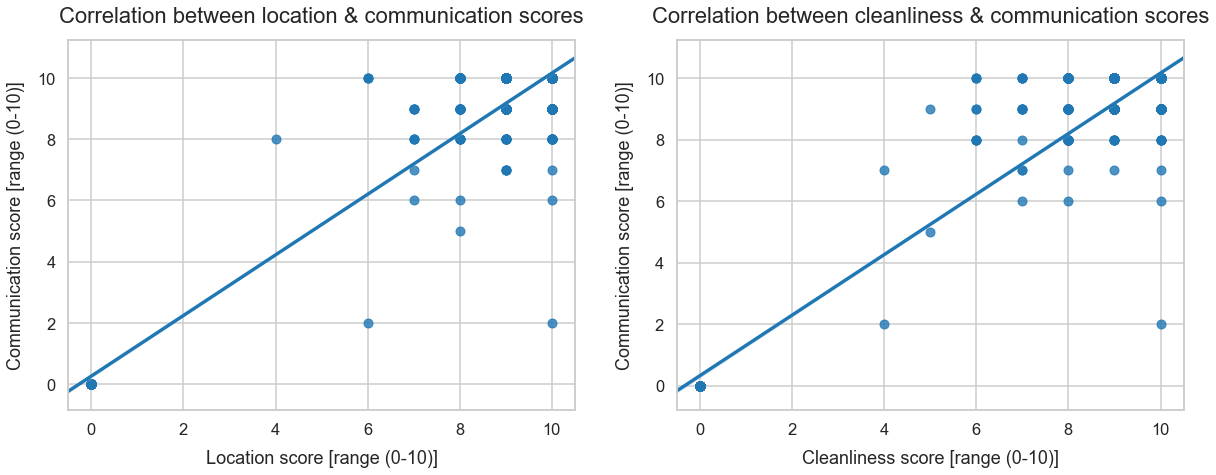

In [117]:
plt.figure(figsize=(20,15))
plt.subplot(221)
sns.regplot(x='review_scores_location', y='review_scores_communication', data=df)
plt.title("Correlation between location & communication scores", fontsize=22, y=1.03)
plt.ylabel("Communication score [range (0-10)]", labelpad=12)
plt.xlabel("Location score [range (0-10)]", labelpad=12)
plt.subplot(222)
sns.regplot(x='review_scores_cleanliness', y='review_scores_communication', data=df)
plt.title("Correlation between cleanliness & communication scores", fontsize=22, y=1.03)
plt.ylabel("Communication score [range (0-10)]", labelpad=12)
plt.xlabel("Cleanliness score [range (0-10)]", labelpad=12)
plt.savefig("image17.png");

## 5.2 Regression for this rating score

In [94]:
X = df.drop('review_scores_rating', axis =1)

In [95]:
X = X.drop(['review_scores_value','review_scores_accuracy'],axis=1)

In [96]:
Y = df['review_scores_rating']

In [97]:
regLasso.fit(X,Y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [98]:
regLasso.coef_

array([  7.46014171e-04,  -0.00000000e+00,  -8.33870978e-03,
        -5.43956139e-17,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,   2.29470250e-03,   8.06663676e-04,
        -4.06024710e-03,  -0.00000000e+00,  -1.19283089e-02,
         0.00000000e+00,  -3.53341896e-04,  -6.40120796e-03,
        -8.75892108e-03,   5.34252741e-03,  -0.00000000e+00,
        -2.08142848e-03,   3.27936909e+00,   1.49223688e+00,
         3.10334246e+00,   1.74524024e+00,  -1.86173274e-02,
         0.00000000e+00,   2.74144679e-04,   4.37323550e-04,
         0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [99]:
{X.columns[i] : regLasso.coef_[i] for i in range(0,len(X.columns))}

{'Air_Conditioning': 0.0,
 'Breakfast': 0.0,
 'Buzzer/Wireless_Intercom': 0.0,
 'Carbon_Monoxide_Detector': 0.0,
 'Dryer': 0.0,
 'Elevator_in_Building': 0.0,
 'Essentials': 0.0,
 'Family/Kid_Friendly': 0.0,
 'Fire_Extinguisher': 0.0,
 'First_Aid_Kit': 0.0,
 'Free_Parking_on_Premises': 0.0,
 'Hair_Dryer': 0.0,
 'Hangers': 0.0,
 'Heating': 0.0,
 'Hot_Tub': 0.0,
 'Indoor_Fireplace': 0.0,
 'Internet': 0.0,
 'Iron': 0.0,
 'Kitchen': 0.0,
 'Laptop_Friendly_Workspace': 0.0,
 'Pets_live_on_this_property': 0.0,
 'Safety_Card': 0.0,
 'Shampoo': 0.0,
 'Smoke_Detector': 0.0,
 'TV': 0.0,
 'Washer': 0.0,
 'accommodates': -0.0,
 'amex': -0.0,
 'availability_30': -0.006401207963089294,
 'availability_365': -0.0,
 'availability_60': -0.0087589210813500476,
 'availability_90': 0.0053425274110080962,
 'bathrooms': 0.0,
 'bed_type_Airbed': 0.0,
 'bed_type_Couch': -0.0,
 'bed_type_Futon': -0.0,
 'bed_type_Pull-out_Sofa': -0.0,
 'bed_type_Real_Bed': 0.0,
 'bed_type_nan': 0.0,
 'bedrooms': 0.0,
 'beds': -0.0

In [100]:
pd.Series({X.columns[i] : regLasso.coef_[i]
            for i in range(0,len(X.columns))} )

Air_Conditioning              0.000000
Breakfast                     0.000000
Buzzer/Wireless_Intercom      0.000000
Carbon_Monoxide_Detector      0.000000
Dryer                         0.000000
Elevator_in_Building          0.000000
Essentials                    0.000000
Family/Kid_Friendly           0.000000
Fire_Extinguisher             0.000000
First_Aid_Kit                 0.000000
Free_Parking_on_Premises      0.000000
Hair_Dryer                    0.000000
Hangers                       0.000000
Heating                       0.000000
Hot_Tub                       0.000000
Indoor_Fireplace              0.000000
Internet                      0.000000
Iron                          0.000000
Kitchen                       0.000000
Laptop_Friendly_Workspace     0.000000
Pets_live_on_this_property    0.000000
Safety_Card                   0.000000
Shampoo                       0.000000
Smoke_Detector                0.000000
TV                            0.000000
Washer                   

In [101]:
s = pd.Series({X.columns[i] : regLasso.coef_[i]
               for i in range(0,len(X.columns))} )
s[s != 0]

availability_30                  -6.401208e-03
availability_60                  -8.758921e-03
availability_90                   5.342527e-03
calculated_host_listings_count   -1.861733e-02
cleaning_fee                     -4.060247e-03
extra_people                     -1.192831e-02
host_listings_count              -8.338710e-03
host_period                       2.741447e-04
host_response_rate                7.460142e-04
host_total_listings_count        -5.439561e-17
maximum_nights                   -3.533419e-04
number_of_reviews                -2.081428e-03
price                             2.294702e-03
review_period                     4.373235e-04
review_scores_checkin             1.492237e+00
review_scores_cleanliness         3.279369e+00
review_scores_communication       3.103342e+00
review_scores_location            1.745240e+00
security_deposit                  8.066637e-04
dtype: float64

## 5.3 Decision Tree Regressor

In [102]:
import sklearn.tree

In [103]:
dt = sklearn.tree.DecisionTreeRegressor(max_depth = 2)

In [104]:
dt.fit(X,Y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [105]:
Y.mean()

84.821767713659611

In [106]:
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

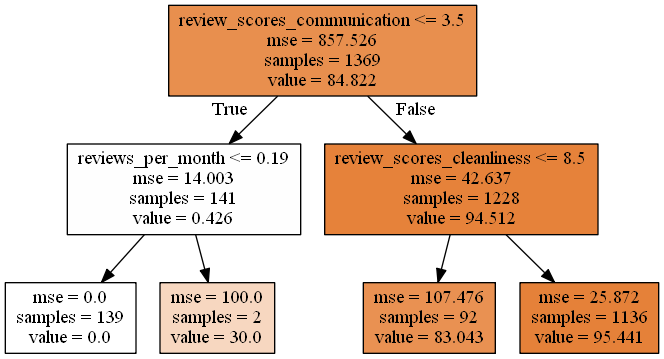

In [110]:
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

Although it is inspiring to get to know the importance of communication over cleaniness in Airbnb busincess.

## 5.4 Regression for Prediction

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,
                                    test_size=.3,random_state=0)

regLasso = linear_model.Lasso()

regLasso.fit(X_train,Y_train)

y_pred = regLasso.predict(X_test)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

## 5.5 Metrics

In [112]:
y_pred

array([  9.50043540e+01,   9.59808674e+01,   9.22399376e+01,
         1.87095596e+00,   9.71560660e+01,   9.78252792e+01,
         9.41076076e+01,   8.78135256e+01,   8.13002925e+01,
         9.07256766e+01,   9.56081291e+01,   9.73823640e+01,
         9.41315428e+01,   5.31529770e-02,   9.24618359e+01,
         8.69795581e+01,   9.73396241e+01,   9.70016316e+01,
         9.76883291e+01,   9.56224306e+01,   9.55529795e+01,
         9.67030384e+01,   9.70241279e+01,   9.70965401e+01,
         9.65551500e+01,   9.37747141e+01,   1.30157708e+00,
         9.76563100e+01,   9.77438598e+01,   9.73906524e+01,
         9.42086807e+01,   8.93393254e+01,   3.64594838e-01,
         9.13832510e+01,   1.56707769e+00,   9.74986950e+01,
         9.77529321e+01,   9.72590120e+01,   8.19881104e+01,
         8.62136838e+01,   9.70152247e+01,   9.53128452e+01,
         9.09750737e+01,   9.32966431e+01,   8.56421550e+01,
         9.34676958e+01,   9.74120130e+01,   9.71344617e+01,
         8.92446722e+01,

In [108]:
(y_pred - Y_test).abs().mean() 

2.6889271985527743

<font color = 'red'> prediction result of rating is quite accurate

In [109]:
((y_pred - Y_test)**2).mean()

24.15207925616448

## 5.6 Find the best regressors

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

regs = [LinearRegression(), ElasticNet(), DecisionTreeRegressor(), GradientBoostingRegressor(), MLPRegressor()]#, SVR()]

In [116]:
from sklearn.model_selection import KFold

minMAD = 10000000
for reg in regs:
    kf = KFold(random_state=0,shuffle=True)
    mad = sklearn.model_selection.cross_val_score(reg,X,Y,
             cv=kf,scoring='neg_mean_absolute_error').mean()
    # need the lowest scoring for mad
    print (str(reg)[:25] + ' with mad= ' + str(mad) )
    if mad < minMAD:
        minMAD = mad
        bestREG = reg
        
print('***********************************************')
print ('Best Regressor is... ' + str(bestREG)[:25] )
print('**********************')
print ('With MAD Score ' + str(minMAD))

LinearRegression(copy_X=T with mad= -222330.209176
ElasticNet(alpha=1.0, cop with mad= -2.89538665446
DecisionTreeRegressor(cri with mad= -3.38492200596
GradientBoostingRegressor with mad= -2.67558581788
MLPRegressor(activation=' with mad= -4.70205747805
***********************************************
Best Regressor is... LinearRegression(copy_X=T
**********************
With MAD Score -222330.209176


## 5.7 GradientBoostingRegressor

In [117]:
gbrt=GradientBoostingRegressor(n_estimators=130, random_state = 0) 
gbrt.fit(X_train, Y_train) 

Y_pred=gbrt.predict(X_test) 
(Y_pred - Y_test).abs().mean()

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=130, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

2.5154366242515716

In [118]:
print "Feature Importances" 
print gbrt.feature_importances_ 
print #Let's print the R-squared value for train/test. 
print "R-squared for Train: %.2f" %gbrt.score(X_train, Y_train) 
print "R-squared for Test: %.2f" %gbrt.score(X_test, Y_test) 

Feature Importances
[  1.07509420e-02   2.12140396e-03   1.79670189e-02   1.05282886e-02
   6.47645924e-02   4.22072194e-02   3.60432330e-03   6.07014556e-03
   4.07789862e-03   9.49939200e-03   3.10780259e-02   2.98785857e-02
   5.74198595e-03   1.14938671e-02   1.87776404e-02   0.00000000e+00
   1.36565033e-02   8.75409507e-03   1.27006027e-02   5.01885165e-03
   1.58169209e-02   3.10138717e-02   6.52439208e-02   3.57469889e-02
   1.33625526e-01   7.50824561e-02   8.60268741e-03   3.78293174e-02
   5.34989856e-02   3.95720295e-02   8.14519996e-03   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.33360135e-03   1.10987983e-03   0.00000000e+00
   0.00000000e+00   6.33921104e-03   0.00000000e+00   0.00000000e+00
   8.19902046e-03   2.22275897e-03   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   4.46602034e-03   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e

## 5.8 MLP Regressor

In [119]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit only to the training data

In [120]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [121]:
from sklearn.neural_network import MLPClassifier

In [122]:
mlp = MLPClassifier(hidden_layer_sizes= (300,300), alpha=0.001, max_iter=40, activation='logistic')

In [123]:
mlp.fit(X_train,Y_train)

MLPClassifier(activation='logistic', alpha=0.001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300, 300), learning_rate='constant',
       learning_rate_init=0.001, max_iter=40, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [124]:
predictions = mlp.predict(X_test)
(predictions - Y_test).abs().mean()

4.1046228710462289

In [125]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(Y_test,predictions))
print(classification_report(Y_test,predictions))

[[50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  2]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0
   0  1  0  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1]
 [ 0  0  0  0  0  0  

## 5.9 Sentiment Analysis on Reviews

In [126]:
data = pd.read_csv('Review.csv')
print(data.columns)

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'listing_id', u'id', u'date',
       u'reviewer_id', u'reviewer_name', u'comments',
       u'comments_no_punctuation', u'sentiment'],
      dtype='object')


In [128]:
positive = data[data['sentiment']>0]

In [130]:
negative = data[data['sentiment']<0]

In [131]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

In [251]:
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=2000         
mpl.rcParams['figure.subplot.bottom']=.1 


stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=100000,
                          max_font_size=40, 
                          random_state=60,
                         ).generate(str(positive['comments_no_punctuation']))

print(wordcloud)
fig = plt.figure(1,figsize = (10,8))
plt.imshow(wordcloud)
plt.axis('off')
fig.savefig("word1.png", dpi=900)

(-0.5, 399.5, 199.5, -0.5)

** <font color='blue'>Managerial insight</font>  : it is important to get good review rating from customers. So, it can be emphasized to Airbnb host that not only cleaniness but also good communcation with customers are very important as well. To do this, Airbnb can suggest and share good way of communications skills and episode with hosts. **

** Moreover, it is important to know our customers' negative sentiment and find ways to improve on it. Based on our sentiment analysis, we found that extremely a lot of negative feeling caused from the fact that they haven't provided the exact location until they matched to the host. ** 

** To improve on this, we can consider several possible solutions. First, provide customers the exact address if possible so that they don't find themselves in wrong location. Second, narrow down the radius of location circle the Airbnb provides. This can help customers to have concrete idea on the house location. Lastly, add location descriptions section for host to write down at least a few sentences to describe what landmarks are around the house. **
